In [1]:
from netCDF4 import Dataset
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime, timedelta
from scipy.stats import norm
import sys
sys.path.append(r'C:\Users\schijven\Documents\Classes\Input_preparation\lib')

C:\Users\schijven\AppData\Local\Temp\ipykernel_8180\3204254232.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%load_ext autoreload
%autoreload 2
from input_preparation_new import Input_prep

## Run the class

In [3]:
# all variables in a yaml file
config_filename=r"C:\Users\schijven\Documents\Data\config.yaml"

In [4]:
test = Input_prep(config_filename)
# train_dataset1_processed, train_dataset2_processed, train_dataset3_processed, train_dataset4_processed, val_dataset1_processed, val_dataset2_processed, val_dataset3_processed, val_dataset4_processed = test.prepare_input_new()
train_dataset_processed, val_dataset_processed = test.prepare_input_new()

INFO:root:Reading configuration file C:\Users\schijven\Documents\Data\config.yaml...
INFO:root:Preparing data with clip interval 2001-07-01 00:00:00 - 2018-09-07 23:00:00. Timewindow = 48.
INFO:root:Tide gauge data from Scheveningen loaded and clipped
INFO:root:Altimetry data loaded and clipped
INFO:root:ERA5 data loaded and clipped
100%|██████████| 150719/150719 [41:47<00:00, 60.11it/s] 
INFO:root:Done!
INFO:root:DOT compiled
INFO:root:udist_vlis compiled
INFO:root:udist_schev compiled
INFO:root:udist_eur compiled
INFO:root:vdist_vlis compiled
INFO:root:vdist_schev compiled
INFO:root:vdist_eur compiled
INFO:root:Time compiled
INFO:root:Altimetry data compiled
INFO:root:Altimetry data padded
INFO:root:Altimetry data concatenated
INFO:root:Batched into single batches
INFO:root:Batches merged
INFO:root:Full dataset size: 150672
INFO:root:Training dataset size: 90404
INFO:root:Validation dataset size: 30134
INFO:root:Testing dataset size: 30134
INFO:root:Start normalizing
INFO:root:ERA5 c

In [5]:
for i in train_dataset_processed:
    print(i)
    break

(<tf.Tensor: shape=(1, 413089), dtype=float32, numpy=
array([[100983.21, 101006.95, 101031.2 , ...,      0.  ,      0.  ,
           182.  ]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[0.069793, 0.      ]]], dtype=float32)>)


In [6]:
for i in val_dataset_processed:
    print(i)
    break

(<tf.Tensor: shape=(1, 413089), dtype=float32, numpy=
array([[9.877558e+04, 9.877185e+04, 9.876798e+04, ..., 0.000000e+00,
        0.000000e+00, 9.100000e+01]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[8.763997e-01, 4.339368e+08]]], dtype=float32)>)


## Get bad, flat and good performance inputs

In [7]:
# Find a date and time where a high water level event occured and visualise the input....
data_clipped, t_clipped = test.load_tide_gauge_data_and_clip()
print(test)

INFO:root:Tide gauge data from Scheveningen loaded and clipped


Class for input preparation of neural network. Attributes: dict_keys(['config', 'start', 'end', 'timewindow', 'means_era5', 'stds_era5', 'alt_shape', 'means_alt', 'stds_alt', 'tmin', 'tmax', 'dmin', 'dmax'])


In [8]:
model_root = Path(r"P:\11207365-eoatsee\Sofie\Data\Saved_models")

def load_output(filename):
    output = np.load(filename, allow_pickle=True)
    output = pd.DataFrame(output, columns=["Time", "SL", "Tides", "resid", "ML"])
    output["Time"] = pd.to_datetime(output.Time).round("h")
    output.set_index("Time", inplace=True)
    return output

# testing period: 2015-04-01  -  2018-09-07
# vlis = load_output(model_root / "Vlissingen/output_full.npy")
schev = load_output(model_root / "Scheveningen/output_full.npy")
# eur = load_output(model_root / "Europlatform/output_full.npy")

In [9]:
def plot_month(true, pred, date_range, title, fontsize=20):
    plt.plot(true, label="TG", color="green")
    plt.plot(pred, label="ML", color="blue")
    plt.grid()
    plt.title(title)
    plt.ylabel("Non-tidal water level [m]", fontsize=fontsize)
    plt.legend(fontsize=fontsize, loc=3)
    plt.ylim(-2, 2.5)
    plt.yticks(ticks=np.arange(-2, 3, 0.5), labels=np.arange(-2, 3, 0.5), fontsize=fontsize)
    newticks = np.arange(date_range[0], date_range[1]+timedelta(days=4), dtype="datetime64[3D]")
    plt.xticks(ticks=newticks, labels=newticks, rotation=30, ha="right", fontsize=fontsize)
    plt.xlim(date_range[0], date_range[1])
    # plt.axvline(datetime(2015, 7, 25, 12), color='k')
    # plt.axvline(datetime(2017, 1, 11), color='k')
    # plt.axvline(datetime(2018, 1, 15, 14), color="k")
    plt.fill_between([datetime(2015, 7, 25), datetime(2015, 7, 26)], -2, 2.5, color="grey", alpha=0.5)
    plt.fill_between([datetime(2016, 11, 20), datetime(2016, 11, 21)], -2, 2.5, color="grey", alpha=0.5)
    plt.fill_between([datetime(2017, 9, 13), datetime(2017, 9, 15)], -2, 2.5, color="grey", alpha=0.5)
    plt.fill_between([datetime(2018, 1, 3), datetime(2018, 1, 4, 10)], -2, 2.5, color="grey", alpha=0.5)
    plt.fill_between([datetime(2018, 1, 18), datetime(2018, 1, 19)], -2, 2.5, color="grey", alpha=0.5)

In [10]:
import logging
logging.disable(logging.DEBUG)

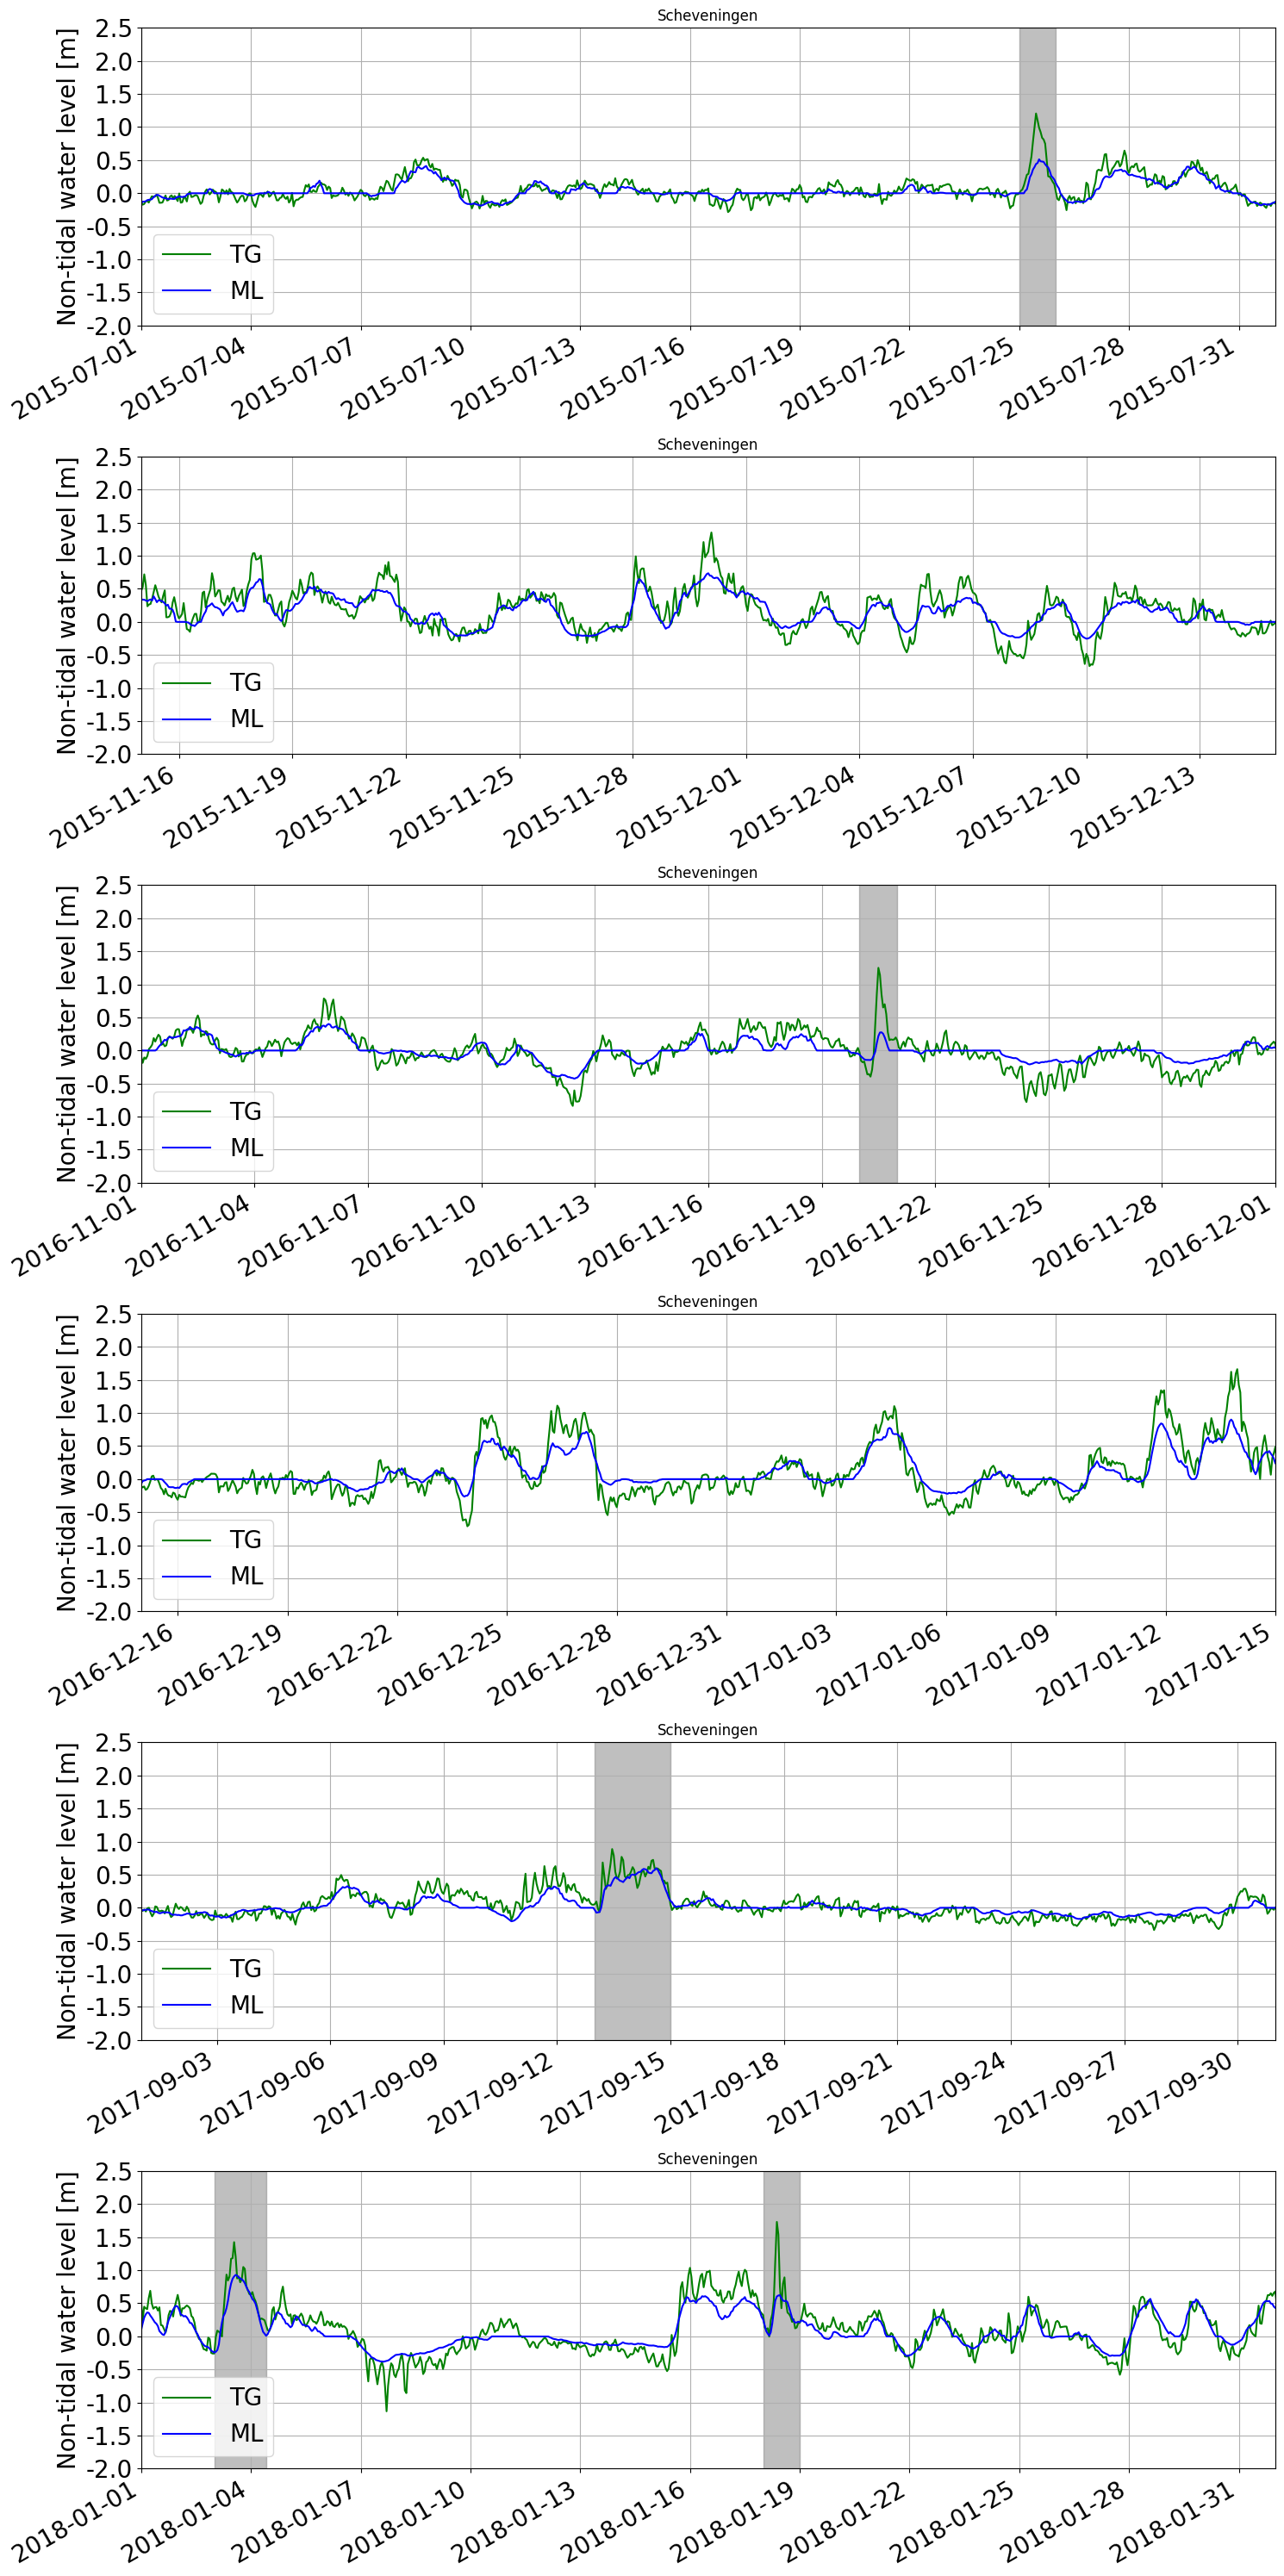

In [11]:
starts = [datetime(2015, 7, 1), datetime(2015, 11, 15), datetime(2016, 11, 1), datetime(2016, 12, 15), datetime(2017, 9, 1), datetime(2018, 1, 1)]
ends = [datetime(2015, 8, 1), datetime(2015, 12, 15), datetime(2016, 12, 1), datetime(2017, 1, 15), datetime(2017, 10, 1), datetime(2018, 2, 1)]

# Scheveningen
plt.figure(figsize=(15,30))
for i in range(6):
    plt.subplot(6,1,i+1)
    plot_month(schev.resid, schev.ML,  (starts[i], ends[i]), "Scheveningen")
plt.tight_layout()
plt.show()

In [268]:
bad_date = datetime(2015, 7, 25, 12)
flat_date = datetime(2016, 12, 31)
good_date = datetime(2018, 1, 3, 17)

i_bad = np.where(schev.index == bad_date)[0][0]
i_flat = np.where(schev.index == flat_date)[0][0]
i_good = np.where(schev.index == good_date)[0][0]

data_bad = val_dataset_processed.skip(i_bad).take(1)
data_flat = val_dataset_processed.skip(i_flat).take(1)
data_good = val_dataset_processed.skip(i_good).take(1)
# print(list(data_bad.as_numpy_iterator())[0])
data_bad = list(data_bad.as_numpy_iterator())[0]
data_flat = list(data_flat.as_numpy_iterator())[0]
data_good = list(data_good.as_numpy_iterator())[0]

In [15]:
era5_root = Path(r"P:\11207365-eoatsee\Sofie\Data\ERA-5\full")
mask_era5 = np.load(era5_root / "mask_p.npy")
grid_lon = np.load(era5_root / "grid_lon.npy")
grid_lat = np.load(era5_root / "grid_lat.npy")

non_nan_indices = np.where(~np.isnan(mask_era5))

In [30]:
def plot_era5(data_masked, ax, fig, fontsize, limit_min, limit_max):
    projection_crs = ccrs.Robinson()
    # fig, ax = plt.subplots(subplot_kw={'projection': projection_crs}, figsize=(10, 8))
    ax.coastlines(resolution="10m")
    ax.add_feature(cfeature.BORDERS, edgecolor='k')
    ax.add_feature(cfeature.OCEAN)
    # Plot the image with NaN values masked
    masked = np.ma.masked_where(np.isnan(data_masked), data_masked)
    grid = ax.imshow(masked[::-1], extent=(grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()), cmap='Spectral_r', vmin=limit_min, vmax=limit_max, origin='lower', transform=ccrs.PlateCarree())
    # ax.set_extent([4, 6, 52.5, 54], crs=ccrs.PlateCarree())
    # ax.set_extent([-10, 10, 45, 65], crs=ccrs.PlateCarree())
    ax.set_extent([-4.5, 9, 48, 60.5], crs=ccrs.PlateCarree())
    x = [-4, 4]
    y = [60, 60]
    x1 = [8.5, 4]
    y1 = [53.5, 60]
    x2 = [-1, 8.5]
    y2 = [48.5, 53.5]
    x3 = [-1, -4]
    y3 = [51, 57]
    x4 = [-4, -4]
    y4 = [60, 57]
    x5 = [-1, -1]
    y5 = [51, 48.5]
    ijx = [5, 5, 5.5, 5.5, 5]
    ijy = [53, 52.5, 52.5, 53, 53]
    ax.plot(x, y, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(ijx, ijy, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(x1, y1, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(x2, y2, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(x3, y3, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(x4, y4, color='red', linewidth=2, transform=ccrs.PlateCarree())
    ax.plot(x5, y5, color='red', linewidth=2, transform=ccrs.PlateCarree())
    
    cbar = fig.colorbar(grid, ax=ax, orientation='vertical', pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
    # cbar.set_label(label)
    # plt.title("ERA5 view")
    # Custom xticks
    # custom_xticks = [-4, -2, 0, 2, 4, 6, 8]
    # ax.set_xticks(custom_xticks, crs=ccrs.PlateCarree())
    # ax.set_xticklabels(['4°W', "2°W", '0°', "2°E", '4°E', "6°E", '8°E'], fontsize=fontsize)

    ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, linewidth=1, xlabel_style={"size": fontsize}, ylabel_style={"size": fontsize}, color='gray', linestyle="dashed", alpha=0.5, x_inline=False)
    
    # Custom yticks
    # custom_yticks = [50, 52, 54, 56, 58, 60]
    # ax.set_yticks(custom_yticks, crs=ccrs.PlateCarree())
    # ax.set_yticklabels(['50°N', '52°N',  '54°N', '56°N', '58°N', '60°N'], fontsize=fontsize)
    # ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5)
    return

In [129]:
param_era5 = 3 # amount of era5 parameters
size_era5 = 1498 # amount of pixels in one era5 figure
param_alt = 8 # amount of altimetry parameters
size_alt = int(((data_bad[0].shape[1] - 1)/48 - param_era5*size_era5)/param_alt)
full_48 = 3*size_era5

# i = 0 #48 hours before
# i = 47 #1 hour before
# projection_crs = ccrs.Robinson()
# fig, ax = plt.subplots(nrows = 1, ncols = 1, subplot_kw={'projection': projection_crs}, figsize=(10, 6))

# p_input = data_bad[0][0][full_48*i : full_48*i + size_era5]
# u_input = data_bad[0][0][full_48*i + size_era5 : full_48*i + 2*size_era5]
# v_input = data_bad[0][0][full_48*i + 2*size_era5 : full_48*i + 3*size_era5]

# lmin = 100000
# lmax = 103000

# lmin = -12
# lmax = 12

# mask_era5[non_nan_indices] = p_input[:len(non_nan_indices[0])][::-1]
# mask_era5[non_nan_indices] = u_input[:len(non_nan_indices[0])][::-1]
# mask_era5[non_nan_indices] = v_input[:len(non_nan_indices[0])][::-1]


# plot_era5(mask_era5, ax, fig, fontsize=16, limit_min=lmin, limit_max=lmax)
# ax.set_title(f"Hour: {i-48}", fontsize=18)
# plt.show()

In [269]:
bad_start = np.datetime64(bad_date).astype("datetime64[s]") - np.datetime64(datetime(2001, 7, 1)).astype("datetime64[s]")
flat_start = np.datetime64(flat_date).astype("datetime64[s]") - np.datetime64(datetime(2001, 7, 1)).astype("datetime64[s]")
good_start = np.datetime64(good_date).astype("datetime64[s]") - np.datetime64(datetime(2001, 7, 1)).astype("datetime64[s]")

numpy.timedelta64(443880000,'s')

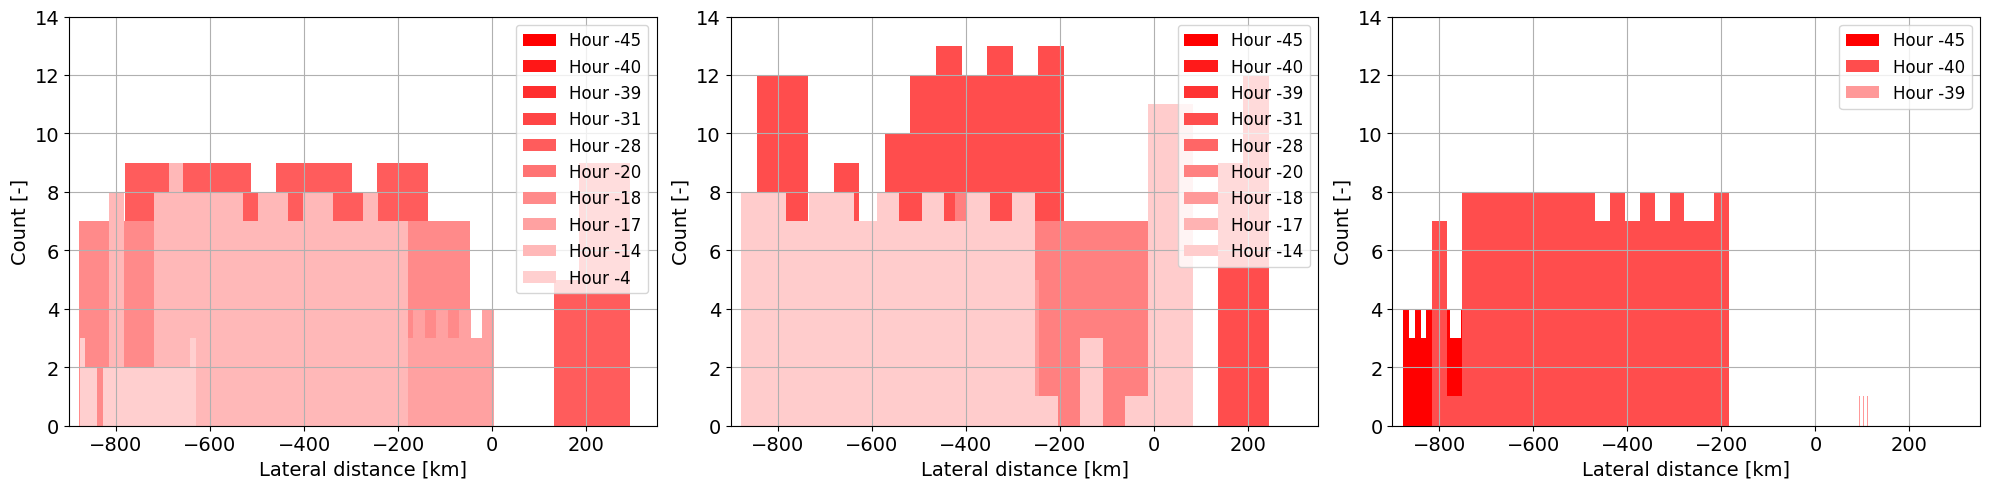

In [383]:
param_nr = 5 # [DOT, udist_vlis, udist_schev, udist_eur, vdist_vlis, vdist_schev, vdist_eur, time]
param_nr2 = 2 # [DOT, udist_schev, vdist_schev]

alt_bad = data_bad[0][0][full_48*48:-1].reshape((48, 8, 514))
alt_flat = data_flat[0][0][full_48*48:-1].reshape((48, 8, 514))
alt_good = data_good[0][0][full_48*48:-1].reshape((48, 8, 514))

bad_ind = np.nonzero(alt_bad.sum(axis=2).sum(axis=1))[0]
flat_ind = np.nonzero(alt_flat.sum(axis=2).sum(axis=1))[0]
good_ind = np.nonzero(alt_good.sum(axis=2).sum(axis=1))[0]

xlim_param = [-3.5, 3.5, -450, 950, -900, 350]

ylim_param = [30, 14, 14]

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
# plt.title(bad_date)
for i in range(len(bad_ind)):
    color = (1.0, 0.9*i/len(bad_ind), 0.9*i/len(bad_ind))  # Adjust the shade of red based on i
    if param_nr == 7:
        t = bad_start - alt_bad[alt_ind[i]][param_nr].astype(np.int64).astype("timedelta64[s]")
        t[t == np.timedelta64(443880000, "s")] = np.timedelta64(0, "s")
        plt.plot(t/3600, color=color, label=f"Hour {alt_ind[i]-47}")
    else:
        x = alt_bad[bad_ind[i]][param_nr]/1000
        # plt.plot(alt_bad[bad_ind[i]][param_nr]/1000, color=color, label=f"Hour {bad_ind[i]-47}")
        plt.hist(x[x!=0], color=color, bins=20, label=f"Hour {bad_ind[i]-47}")
plt.legend(fontsize=12, loc=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xlim_param[param_nr2*2], xlim_param[param_nr2*2+1])
plt.ylim(0, ylim_param[param_nr2])
# plt.xlim(-3.5, 3.5)
# plt.ylim(0, 30)
# plt.xlabel("Nr. of observations [-]", fontsize=14)
plt.ylabel("Count [-]", fontsize=14)
plt.xlabel("Lateral distance [km]", fontsize=14)
plt.grid()
plt.subplot(1,3,2)
# plt.title(flat_date)
for i in range(len(flat_ind)):
    color = (1.0, 0.9*i/len(flat_ind), 0.9*i/len(flat_ind))  # Adjust the shade of red based on i
    if param_nr == 7:
        t = flat_start - alt_flat[flat_ind[i]][param_nr].astype(np.int64).astype("timedelta64[s]")
        t[t == t[-1]] = np.timedelta64(0, "s")
        plt.plot(t/3600, color=color, label=f"Hour {flat_ind[i]-47}")
    else:
        x = alt_flat[flat_ind[i]][param_nr]/1000
        # plt.plot(alt_flat[flat_ind[i]][param_nr]/1000, color=color, label=f"Hour {flat_ind[i]-47}")
        plt.hist(x[x!=0], color=color,  bins=20, label=f"Hour {bad_ind[i]-47}")
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xlim_param[param_nr2*2], xlim_param[param_nr2*2+1])
plt.ylim(0, ylim_param[param_nr2])
# plt.ylim(-3, 3.5)
# plt.ylim(0, 30)
# plt.xlabel("Nr. of observations [-]", fontsize=14)
plt.ylabel("Count [-]", fontsize=14)
plt.xlabel("Lateral distance [km]", fontsize=14)
plt.grid()
plt.subplot(1,3,3)
# plt.title(good_date)
for i in range(len(good_ind)):
    color = (1.0, 0.9*i/len(good_ind), 0.9*i/len(good_ind))  # Adjust the shade of red based on i
    if param_nr == 7:
        t = good_start - alt_good[good_ind[i]][param_nr].astype(np.int64).astype("timedelta64[s]")
        t[t == t[-1]] = np.timedelta64(0, "s")
        plt.plot(t/3600, color=color, label=f"Hour {good_ind[i]-47}")
    else:
        x = alt_good[good_ind[i]][param_nr]/1000
        # plt.plot(alt_good[good_ind[i]][param_nr]/1000, color=color, label=f"Hour {good_ind[i]-47}")
        plt.hist(x[x!=0], color=color, bins=20, label=f"Hour {bad_ind[i]-47}")
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xlim_param[param_nr2*2], xlim_param[param_nr2*2+1])
plt.ylim(0, ylim_param[param_nr2])
# plt.ylim(-3, 3.5)
# plt.ylim(0, 30)
plt.ylabel("Count [-]", fontsize=14)
plt.xlabel("Lateral distance [km]", fontsize=14)
plt.grid()
plt.tight_layout()

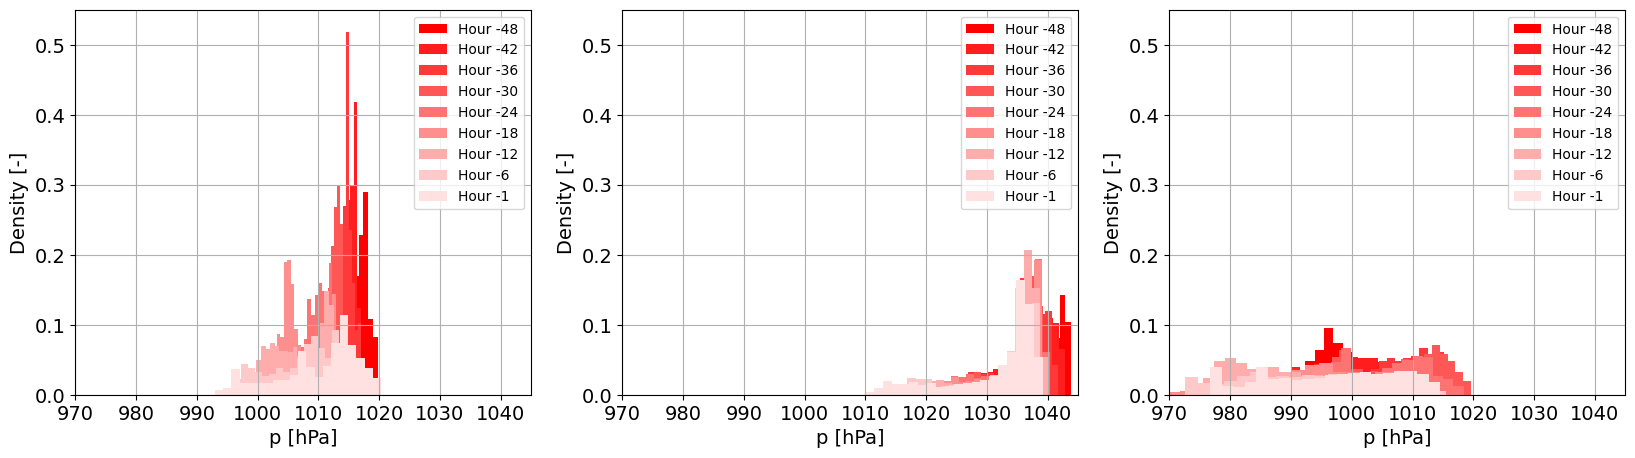

In [387]:
plot_every = 6 #hours
param = 0 # 0 = p, 1 = U10, 2 = V10
labels = ["p [hPa]", "U10 [m/s]", "V10 [m/s]"]
label_param = labels[param]

d = int(48/plot_every)
xlim_param = [970, 1045, -16, 22, -16, 22]
ylim_param = [0.55, 0.37, 0.37]

# ERA5

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
# plt.title(bad_date, fontsize=14)
for i in range(int(48/plot_every)+1):
    if i == int(48/plot_every):
        i = 47
    else:
        i = i*plot_every
    # print(i)
    v_i = data_bad[0][0][full_48*i + 2*size_era5 : full_48*i + 3*size_era5]
    u_i = data_bad[0][0][full_48*i + size_era5 : full_48*i + 2*size_era5]
    p_i = data_bad[0][0][full_48*i : full_48*i + size_era5]
    data_i = [p_i/100, u_i, v_i]
    color = (1.0, 0.9*i/48, 0.9*i/48)  # Adjust the shade of red based on i
    plt.hist(data_i[param], color=color, bins=20, label=f"Hour {i-48}", density=True)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(label_param, fontsize=14)
plt.xlim(xlim_param[param*2], xlim_param[param*2+1])
plt.ylim(0, ylim_param[param])
plt.legend(fontsize=10)
plt.ylabel("Density [-]", fontsize=14)
plt.subplot(1,3,2)
# plt.title(flat_date, fontsize=14)
for i in range(int(48/plot_every)+1):
    if i == int(48/plot_every):
        i = 47
    else:
        i = i*plot_every
    # print(i)
    v_i = data_flat[0][0][full_48*i + 2*size_era5 : full_48*i + 3*size_era5]
    u_i = data_flat[0][0][full_48*i + size_era5 : full_48*i + 2*size_era5]
    p_i = data_flat[0][0][full_48*i : full_48*i + size_era5]
    data_i = [p_i/100, u_i, v_i]
    color = (1.0, 0.9*i/48, 0.9*i/48)  # Adjust the shade of red based on i
    plt.hist(data_i[param], color=color, bins=20, label=f"Hour {i-48}", density=True)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(label_param, fontsize=14)
plt.xlim(xlim_param[param*2], xlim_param[param*2+1])
plt.ylim(0, ylim_param[param])
plt.legend(fontsize=10)
plt.ylabel("Density [-]", fontsize=14)
plt.subplot(1,3,3)
# plt.title(good_date, fontsize=14)
for i in range(int(48/plot_every)+1):
    if i == int(48/plot_every):
        i = 47
    else:
        i = i*plot_every
    # print(i)
    v_i = data_good[0][0][full_48*i + 2*size_era5 : full_48*i + 3*size_era5]
    u_i = data_good[0][0][full_48*i + size_era5 : full_48*i + 2*size_era5]
    p_i = data_good[0][0][full_48*i : full_48*i + size_era5]
    data_i = [p_i/100, u_i, v_i]
    color = (1.0, 0.9*i/48, 0.9*i/48)  # Adjust the shade of red based on i
    plt.hist(data_i[param], color=color, bins=20, label=f"Hour {i-48}", density=True)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, ylim_param[param])
plt.xlabel(label_param, fontsize=14)
plt.xlim(xlim_param[param*2], xlim_param[param*2+1])
plt.legend(fontsize=10)
plt.ylabel("Density [-]", fontsize=14)
plt.show()

## Train ML model

In [7]:
train = train_dataset_processed
validation = val_dataset_processed

In [8]:
# Resampling and model definition

tf.random.set_seed(16)
learning_rate = 0.0001 # a learning rate of 0.001 results in a straight line!

input_shape = next(iter(train.as_numpy_iterator()))[0].shape

# Define the neural network architecture
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),
        tf.keras.layers.Dense(32, activation='relu', dtype="float32"),
        tf.keras.layers.Dense(1, dtype="float32")
    ], name="My_model")
    return model

# Create the model
model = create_model()

# Create an instance of the Adam optimizer with the desired learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['MeanAbsoluteError'])

# Apply importance sampling
y_train_map = train.flat_map(lambda x, y: tf.data.Dataset.from_tensor_slices(y))             # Get target values
y_train = np.concatenate(list(y_train_map.as_numpy_iterator()))                              # Convert to numpy array
print("Concatenated")
dist_c = norm.cdf(abs(y_train))                                                              # Compute cumulative distribution function

dataset = tf.data.Dataset.zip((train, tf.data.Dataset.from_tensor_slices(dist_c)))

def transform_element(element1, element2):
    # Unpack the original tuple
    tensor1, tensor2 = element1
    tensor3 = element2
    # Add the third tensor to create three tuples
    return (tensor1, tensor2, tensor3)

# Apply the transformation to each element of the original dataset
transformed_dataset = dataset.map(transform_element)
print("Transformed")

Concatenated
Transformed


In [9]:
threshold_cdf = 0.8
# new_ratio_high = 0.05
k = 11.3
old_ratio_high = np.where(dist_c>threshold_cdf)[0].shape[0]/dist_c.shape[0]

dataset1 = transformed_dataset.filter(lambda x, y, z: z < threshold_cdf)
dataset2 = transformed_dataset.filter(lambda x, y, z: z > threshold_cdf)

new_ratio_high = k*old_ratio_high
# k = new_ratio_high/(np.where(dist_c>threshold_cdf)[0].shape[0]/dist_c.shape[0])
print("New ratio:", new_ratio_high)
dataset2 = dataset2.repeat(int(k))

# this resamples the data with a new distribution. Takes a lot of time to compute though!
sample_dataset = tf.data.Dataset.sample_from_datasets(
    [dataset1, dataset2], weights=[1-new_ratio_high, new_ratio_high])

New ratio: 0.09449581876908103


In [10]:
# Takes very long!
# y_train_new_map = sample_dataset.flat_map(lambda x, y, z: tf.data.Dataset.from_tensor_slices(y))             # Get target values
# print("Mapping...")
# y_train_new = np.concatenate(list(y_train_new_map.as_numpy_iterator()))                              # Convert to numpy array

# plt.hist(y_train_new, label="Resampled", density=True)
# plt.hist(y_train, alpha=0.5, label="Original sampled", density=True)
# plt.legend()

# print(y_train_new.shape, y_train.shape)

In [11]:
train_batch = sample_dataset.batch(32)
val_batch = validation.batch(32)

In [ ]:
# runs for ~16 hours
history = model.fit(train_batch, validation_data = val_batch, epochs=30)

Epoch 1/30



   1557/Unknown - 2269s 1s/step - loss: 1761.5212 - mean_absolute_error: 31.1078

In [ ]:
model_root = Path(r"C:\Users\schijven\Documents\Data\Saved_models\Scheveningen_test")
model.save(model_root / 'Scheveningen2.keras')

In [ ]:
model.summary()

In [ ]:
import logging
logging.disable(logging.DEBUG)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label = "Training")
plt.plot(history.history['val_loss'], label = "Validation")
plt.legend()
plt.grid()
plt.title('Loss')
plt.yscale('log')

In [ ]:
train_batch_2 = train.batch(32)
y_hat_train = model.predict(train_batch_2)
y_hat_val = model.predict(val_batch)

In [ ]:
tg_data = pd.read_csv(r"C:\Users\schijven\Documents\Data\scheveningen-schevngn-nld-rwsHatyan.csv")
tg_data.datetime = pd.to_datetime(tg_data.datetime)
tg_data.set_index("datetime", inplace=True)
tg_data = tg_data[(tg_data.index >= test.start) & (tg_data.index <= test.end)]

train_ratio = test.config["variables"]["train_ratio"]
test_ratio = 1-train_ratio
train_ratio2 = test.config["variables"]["train_ratio2"]
val_ratio = 1-train_ratio2

train_size = int(np.round(len(tg_data)*train_ratio))
t = tg_data.index.values
t_train = t[:train_size]

train_size2 = int(np.round(len(t_train)*train_ratio2))
val_size = int(np.round(len(t_train)*val_ratio))

# Fold 1
# t_train1 = t_train[:train_size2]
# t_val1 = t_train[train_size2:]
# target1 = tg_data.loc[t_val1]
# train1 = tg_data.loc[t_train1]
# target1["ML"] = y_hat_val.reshape(y_hat_val.shape[0])
# train1["ML"] = y_hat_train.reshape(y_hat_train.shape[0])
# target1.reset_index(inplace=True)
# train1.reset_index(inplace=True)

# Fold 2
t_train21 = t_train[:val_size]
t_train22 = t_train[2*val_size:]
t_train2 = np.concatenate([t_train21, t_train22])
t_val2 = t_train[val_size:2*val_size]
target2 = tg_data.loc[t_val2]
train2 = tg_data.loc[t_train2]
target2["ML"] = y_hat_val.reshape(y_hat_val.shape[0])
train2["ML"] = y_hat_train.reshape(y_hat_train.shape[0])
target2.reset_index(inplace=True)
train2.reset_index(inplace=True)

# Fold 3
# t_train31 = t_train[:2*val_size]
# t_train32 = t_train[3*val_size:]
# t_train3 = np.concatenate([t_train31, t_train32])
# t_val3 = t_train[2*val_size:3*val_size]
# target3 = tg_data.loc[t_val3]
# train3 = tg_data.loc[t_train3]
# target3["ML"] = y_hat_val.reshape(y_hat_val.shape[0])
# train3["ML"] = y_hat_train.reshape(y_hat_train.shape[0])
# target3.reset_index(inplace=True)
# train3.reset_index(inplace=True)

# Fold 4
# t_train4 = t_train[val_size:]
# t_val4 = t_train[:val_size]
# target4 = tg_data.loc[t_val4]
# train4 = tg_data.loc[t_train4]
# target4["ML"] = y_hat_val.reshape(y_hat_val.shape[0])
# train4["ML"] = y_hat_train.reshape(y_hat_train.shape[0])
# target4.reset_index(inplace=True)
# train4.reset_index(inplace=True)

In [ ]:
hist = pd.DataFrame(history.history)
hist.to_csv(model_root / "history2.csv")

In [ ]:
np.save(model_root / "output2.npy", target2)
np.save(model_root / "train2_output.npy", train2)

In [ ]:
batch_size = 32
# Create the main figure and axis (left axis)
fig, ax1 = plt.subplots(figsize=(10, 5))

line2 = ax1.plot(train2.datetime, train2.resid, label='TG', color='green')
line1 = ax1.plot(train2.datetime, train2.ML, label='ML', color='blue')

ax1.set_ylabel('Water level [m]')
ax1.tick_params(axis='y')

# Combine legend handles and labels
lines = line1 + line2 #+ line3
labels = [line.get_label() for line in lines]

# Create a single legend for both sides in one box
fig.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.84, 0.82))

# Add grid, legends, and title
ax1.grid()
ax1.set_title('Europlatform')

# Set the x-axis limits
# ax1.set_xlim(times_train[-20] - pd.DateOffset(weeks=8), times_train[-20])
ax1.set_xlim(train2.datetime.values[-200] - pd.DateOffset(weeks=8), train2.datetime.values[-200])
# ax1.set_xlim(datetime(2003, 11, 1), datetime(2004, 1, 15))
ax1.set_ylim(-1.5, 2.5)

# Show the plot
plt.show()

In [ ]:
batch_size = 32
# Create the main figure and axis (left axis)
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first line on the left axis
line2 = ax1.plot(target2.datetime, target2.resid, label='TG', color='green')
line1 = ax1.plot(target2.datetime, target2.ML, label='ML', color='blue')

ax1.set_ylabel('Water level [m]')
ax1.tick_params(axis='y')

# Combine legend handles and labels
lines = line1 + line2 #+ line3
labels = [line.get_label() for line in lines]

# Create a single legend for both sides in one box
fig.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.84, 0.82))

# Add grid, legends, and title
ax1.grid()
ax1.set_title('Europlatform')

# Set the x-axis limits
ax1.set_xlim(target2.datetime.values[-200] - pd.DateOffset(weeks=8), target2.datetime.values[-200])
# ax1.set_xlim(datetime(2007, 12, 15), datetime(2008, 1, 15))
ax1.set_ylim(-1.5, 2.5)

# Show the plot
plt.show()